# Spatial transcriptomics unveils the in situ cellular and molecular hallmarks of the lung in fatal COVID-19

# Spatio-temporal trajectory inference analysis

**Author:** Carlos A. Garcia-Prieto

* This notebook explains the spatio-temporal trajectory inference analysis to characterize AT2-AT1 differentiation using [stLearn.](https://stlearn.readthedocs.io/en/latest/)
* We followed stLearn spatial trajectory inference analysis [tutorial.](https://stlearn.readthedocs.io/en/latest/tutorials/Pseudo-time-space-tutorial.html)

## Import modules

In [1]:
import warnings
warnings.filterwarnings("ignore")
import stlearn as st
import scanpy as sc
import numpy, warnings
numpy.warnings = warnings
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np
import pandas as pd

In [2]:
#Set result folders
stlearn_folder = "/Users/carlosgarciaprieto/Proyectos_IJC/Spatial/COVID/Results/Python/HLCA_publication/Results/cell2location_map_finest/Plots/stlearn/Paper/Laptop"
#stlearn_test_folder = "/Users/carlosgarciaprieto/Proyectos_IJC/Spatial/COVID/Results/Python/HLCA_publication/Results/cell2location_map_finest/Plots/stlearn/Paper/Laptop"
#liana_folder = "/Users/carlosgarciaprieto/Proyectos_IJC/Spatial/COVID/Results/Python/HLCA_publication/Results/cell2location_map_finest/Plots/stlearn/Paper/Laptop"
#results_folder = "/Users/carlosgarciaprieto/Proyectos_IJC/Spatial/COVID/Results/Python/HLCA_publication/Results/cell2location_map_finest/Plots/stlearn/Paper/Laptop"

In [3]:
#Read anndata with TF enrichment results:
adata_file = f"{stlearn_folder}/ad_vis_post_distrib_finest_discrete_region_NMF_lineage_decoupler_mlm_Paper.h5ad"
adata = sc.read_h5ad(adata_file)

In [4]:
# Convert AnnData object to work with stLearn
adata.var_names = adata.var_names.astype(str)
adata = st.convert_scanpy(adata)

In [5]:
#Set samples by condition
covid19_proliferative = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17"]
covid19_acute = ["L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18"]
controls = ["L3C","L14C","L2C","CONTROL2"]
covid19 = ["L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18","L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17"]

In [6]:
#Select proliferative DAD case with sufficient AT2 and AT1 cells
sample = ["HRC11"]
sample_name = "HRC11"
adata_covid = adata[adata.obs['sample'].isin(sample)]

## Select cell types of interest: pneumocytes

In [7]:
#Subset annData object with pneumocytes
adata_covid_AT = adata_covid.copy()

In [8]:
#Select spots enriched in pneumocytes
adata_covid_AT = adata_covid_AT[adata_covid_AT.obs["Max_Abundance_Cell"].isin(["AT1","AT2","AT2 proliferating","AT0"])]
adata_covid_AT_quantile = adata_covid_AT.obs["Max_Abundance"].quantile(0.7) #Pneumocytes represented at least 70% of the maximum abundance of the inferred spot composition
adata_covid_AT = adata_covid_AT[adata_covid_AT.obs["Max_Abundance"]>=adata_covid_AT_quantile]

### Preparation

In [9]:
#Filter .uns['spatial'] using list comprehension getting selective dictionary keys
adata_covid.uns["spatial"] = {key: adata_covid.uns["spatial"][key] for key in sample}
adata_covid_AT.uns["spatial"] = {key: adata_covid_AT.uns["spatial"][key] for key in sample}

In [10]:
#Change code for tiling images
##!nano +56 /Users/carlosgarciaprieto/anaconda3/envs/stlearn/lib/python3.8/site-packages/stlearn/image_preprocessingimage_tiling.py
##Replace adata.uns["spatial"][library_id]["images"][adata.uns["spatial"][library_id]["use_quality"]] by adata.uns["spatial"][library_id]["images"]["hires"]
st.pp.tiling(adata_covid_AT,out_path=f"{stlearn_folder}/tiling",crop_size = 40, library_id = f"{sample_name}")

Tiling image: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


In [11]:
#Deep Learning to extract feature
st.pp.extract_feature(adata_covid_AT)

2024-07-18 19:56:42.159710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 19:56:49.720031: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Extract feature: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


### Run stSME clustering

In [12]:
#Run PCA for gene expression data
st.em.run_pca(adata_covid_AT,n_comps=50,random_state=0)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [13]:
#Copy data
data_SME = adata_covid_AT.copy()

In [14]:
#Apply stSME to normalize log transformed data with weights from morphological Similarly and physical distance
st.spatial.SME.SME_normalize(data_SME, use_data="raw", weights="weights_matrix_pd_md")
data_SME.X = data_SME.obsm['raw_SME_normalized']
st.pp.scale(data_SME)
st.em.run_pca(data_SME,n_comps=50)

Adjusting data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]

The data adjusted by SME is added to adata.obsm['raw_SME_normalized']
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [15]:
#K-means clustering on stSME normalized PCA
st.tl.clustering.kmeans(data_SME,n_clusters=2, use_data="X_pca", key_added="X_pca_kmeans") #2 clusters (AT1 and AT2 cells)

Applying Kmeans cluster ...
Kmeans cluster is done! The labels are stored in adata.obs["kmeans"]


In [16]:
#Set cluster color
data_SME.obs["X_pca_kmeans"] = np.where(data_SME.obs["X_pca_kmeans"] == "0", "1", "0") #May be run twice to label AT2 cells as cluster 1
data_SME.obs = data_SME.obs.astype({"X_pca_kmeans":'category'}) 

In [17]:
#Save results
kmeans_abundance = data_SME.obs[['X_pca_kmeans', 'Max_Abundance_Cell']].value_counts()
kmeans_abundance.to_csv(f"{stlearn_folder}/{sample_name}_PSTS_kmeans_2_abundance_ATs_Paper.csv", index=True)

# Spatial trajectory inference

### Choosing root

In [18]:
#Create raw attribute
data_SME.raw = data_SME
#Select AT2 cluster
data_SME.uns["iroot"] = st.spatial.trajectory.set_root(data_SME,use_label="X_pca_kmeans",cluster=1,use_raw=True) 

### Perform pseudotime analysis

In [19]:
st.spatial.trajectory.pseudotime(data_SME,eps=25,use_label="X_pca_kmeans", use_rep = "raw", n_neighbors=20) #eps=25 to avoid no convergence

All available trajectory paths are stored in adata.uns['available_paths'] with length < 4 nodes


### We run the global level of pseudo-time-space (PSTS) method to reconstruct the spatial trajectory between AT2 and AT1 cells

In [20]:
#Select AT2 and AT1 clusters
subclusters = ["1","0"] 
subclusters_name = "1_0"

In [21]:
#Perform pseudo-time-space analysis with global level
st.spatial.trajectory.pseudotimespace_global(data_SME,use_label="X_pca_kmeans",list_clusters=subclusters)

Start to construct the trajectory: 1 -> 0


# Plot spatial trajectory

<div class="alert alert-info">
<b>Paper Figure!</b>
Panel Figure 5C
</div>

In [22]:
with mpl.rc_context({'axes.facecolor':  'white',
                        'figure.figsize': [6, 6]}):
    st.pl.cluster_plot(data_SME,use_label="X_pca_kmeans",show_trajectories=True,list_clusters=subclusters,show_subcluster=True, show_cluster_labels=False, margin=200)
plt.savefig(f"{stlearn_folder}/{sample_name}_PSTS_kmeans_{subclusters_name}_Paper.png",dpi=300, format="png",pad_inches=0.2,bbox_inches="tight")  
plt.close()

In [23]:
with mpl.rc_context({'axes.facecolor':  'white',
                        'figure.figsize': [4, 4]}):
    st.pl.cluster_plot(data_SME,use_label="X_pca_kmeans",show_trajectories=False,list_clusters=subclusters,show_subcluster=False, show_cluster_labels=False, margin=200)
plt.savefig(f"{stlearn_folder}/{sample_name}_PSTS_kmeans_{subclusters_name}_no_trajectory_no_subclusters_Paper.png",dpi=300, format="png",pad_inches=0.2,bbox_inches="tight") 
plt.close()

In [24]:
with mpl.rc_context({'axes.facecolor':  'white',
                        'figure.figsize': [1, 2]}):
    st.pl.trajectory.tree_plot(data_SME, show_plot=False, show_all=True, ncols=4, use_label="X_pca_kmeans", fontsize=5, zoom=0.1)
plt.savefig(f"{stlearn_folder}/{sample_name}_PSTS_kmeans_{subclusters_name}_trajectory_tree_Paper.png",dpi=300, format="png",pad_inches=0.2,bbox_inches="tight") 
plt.close()

# Transition markers detection

In [25]:
#Select clade
clade_number = 6 #Repeat with clade 9
clade_name = f"clade_{clade_number}"

In [26]:
#Transition markers detection of clade 6
st.spatial.trajectory.detect_transition_markers_clades(data_SME,clade=clade_number,use_raw_count=False,cutoff_spearman=0.4) #0.4 default correlation

Detecting the transition markers of clade_6...
Transition markers result is stored in adata.uns['clade_6']


In [27]:
#Select clade
clade_number = 9 
clade_name = f"clade_{clade_number}"

In [28]:
#Transition markers detection of clade 9
st.spatial.trajectory.detect_transition_markers_clades(data_SME,clade=clade_number,use_raw_count=False,cutoff_spearman=0.4) #0.4 default correlation

Detecting the transition markers of clade_9...
Transition markers result is stored in adata.uns['clade_9']


# Plot top 10 transition markers

<div class="alert alert-info">
<b>Paper Figure!</b>
Panel Figure 5C
</div>

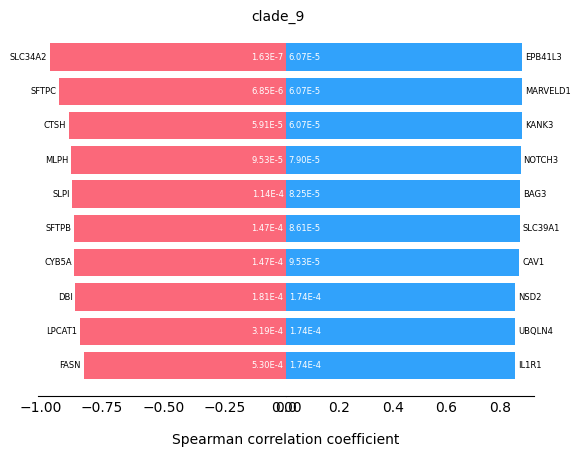

In [29]:
st.pl.trajectory.transition_markers_plot(data_SME,top_genes=10,trajectory=f"{clade_name}", dpi=300, name=f"{sample_name}_PSTS_kmeans_2_{subclusters_name}_{clade_name}_markers_Top10_Paper.png", output=stlearn_folder)


## Compare transition markers between the two clades

In [30]:
st.spatial.trajectory.compare_transitions(data_SME,trajectories=["clade_6","clade_9"])

The result of comparison between clade_6 and clade_9 stored in 'adata.uns['compare_result']'


## Plot differential expression between transition markers

<div class="alert alert-info">
<b>Paper Figure!</b>
Panel Figure 5C
</div>

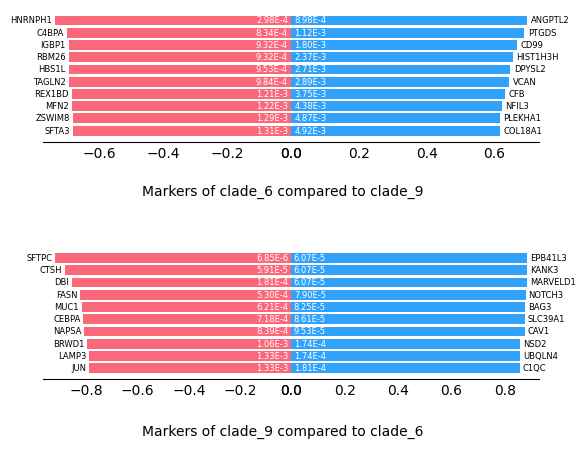

In [31]:
st.pl.trajectory.DE_transition_plot(data_SME)